## 단어 단위의 번역기 만들기

### 1. 정제, 정규화, 전처리
---
- 구두점과 단어를 분리한다
- 소문자로 바꾼다
- 띄어쓰기 단위로 토큰화한다.
- 시작 토큰과 종료 토큰을 추가한다

In [1]:
import pandas as pd
import numpy as np
import os

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [2]:
file_path = os.getenv("HOME") + "/project/aiffel/e/e15/data/fra.txt"
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플:', len(lines))
lines.sample(5)

전체 샘플: 178009


,eng,fra,cc
157477,"And while I'm at it, I have another question.","Et pendant que j'y suis, j'ai une autre question.",CC-BY 2.0 (France) Attribution: tatoeba.org #6...
175481,I don't have time to deal with this letter. Co...,Je n'ai pas le temps de m'occuper de cette let...,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
53534,Can I offer you a drink?,Puis-je vous offrir un verre?,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
27455,Where are my books?,Où sont mes livres ?,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
166895,The President of the United States is now in J...,Le président des États-Unis est actuellement a...,CC-BY 2.0 (France) Attribution: tatoeba.org #3...


In [3]:
lines = lines[['eng', 'fra']][:33000]
lines.sample(5)

,eng,fra
11522,I'll follow you.,Je vous suivrai.
9393,Tom is packing.,Tom fait ses bagages.
20870,Show me the money.,Montre-moi l'argent.
744,I'm fussy.,Je suis difficile.
6235,It's too late.,Il est trop tard.


In [4]:
import re

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!]+", " ", sentence)
    sentence = sentence.strip()
    sentence = sentence.split(" ")
    return sentence

def preprocess_sentence_decoder(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!]+", " ", sentence)
    sentence = sentence.strip()
    sentence = '<start> ' + sentence + ' <end>'
    sentence = sentence.split(" ")
    return sentence

In [5]:
lines.eng = lines.eng.apply(lambda x: preprocess_sentence(x))
lines.fra = lines.fra.apply(lambda x: preprocess_sentence_decoder(x))

In [6]:
lines.eng.sample(5)

21902       [we, train, together, .]
16184        [rabbits, can, swim, .]
5145            [get, your, coat, .]
28534    [do, you, like, english, ?]
14236      [he, gave, it, to, me, .]
Name: eng, dtype: object

In [7]:
lines.fra.sample(5)

700                     [<start>, je, vivrai, ., <end>]
25971         [<start>, elle, parle, chinois, ., <end>]
22191         [<start>, o, peuvent, ils, tre, ?, <end>]
4775              [<start>, tu, l, as, bless, ., <end>]
30886    [<start>, c, tait, assez, effrayant, ., <end>]
Name: fra, dtype: object

### 2. 텍스트를 숫자로
---
- 케라스 토크나이저

In [8]:
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(lines.eng)
input_text = eng_tokenizer.texts_to_sequences(lines.eng)
input_text[:3]

[[30, 1], [1132, 1], [1132, 1]]

In [9]:
fra_tokenizer = Tokenizer()
fra_tokenizer.fit_on_texts(lines.fra)
target_text = fra_tokenizer.texts_to_sequences(lines.fra)
target_text[:3]

[[1, 91, 12, 2], [1, 1068, 12, 2], [1, 1068, 3, 2]]

In [10]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기: ', eng_vocab_size)
print('프랑스어 단어장의 크기: ', fra_vocab_size)

영어 단어장의 크기:  4662
프랑스어 단어장의 크기:  7326


In [11]:
max_eng_len = max([len(line) for line in input_text])
max_fra_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이: ', max_eng_len)
print('프랑스어 시퀀스의 최대 길이: ', max_fra_len)

영어 시퀀스의 최대 길이:  8
프랑스어 시퀀스의 최대 길이:  17


In [12]:
sos_token = '<start>'
eos_token = '<end>'

encoder_input = input_text
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[eos_token]] for line in target_text]
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[sos_token]] for line in target_text]

print(decoder_input[:5])
print(decoder_target[:5])

[[1, 91, 12], [1, 1068, 12], [1, 1068, 3], [1, 928, 12], [1, 2190, 12]]
[[91, 12, 2], [1068, 12, 2], [1068, 3, 2], [928, 12, 2], [2190, 12, 2]]


In [13]:
encoder_input = pad_sequences(encoder_input, maxlen=max_eng_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen=max_fra_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen=max_fra_len, padding='post')

print('영어 데이터의 shape: ', np.shape(encoder_input))
print('프랑스어 입력 데이터의 shape: ', np.shape(decoder_input))
print('프랑스어 출력 데이터의 shape: ', np.shape(decoder_target))

영어 데이터의 shape:  (33000, 8)
프랑스어 입력 데이터의 shape:  (33000, 17)
프랑스어 출력 데이터의 shape:  (33000, 17)


In [14]:
print(encoder_input[0])

[30  1  0  0  0  0  0  0]


In [15]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[ 7420  2885 12894 ... 17916 15362 13415]


In [21]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print(encoder_input_train.shape)
print(decoder_input_train.shape)
print(decoder_target_train.shape)

print(encoder_input_test.shape)
print(decoder_input_test.shape)
print(decoder_target_test.shape)

(30000, 8)
(30000, 17)
(30000, 17)
(3000, 8)
(3000, 17)
(3000, 17)


### 3. 임베딩 레이어 
---
- 케라스 임베딩 레이어
- 인코더와 디코더의 임베딩은 서로 다르지만 훈련 과정과 테스트 과정의 임베딩은 동일

In [17]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

In [22]:
encoder_inputs = Input(shape=(None,))

enc_emb = Embedding(eng_vocab_size, 256, input_length=max_eng_len)(encoder_inputs)
enc_masking = Masking(mask_value=0.0)(enc_emb)
encoder_lstm = LSTM(units = 256, return_state = True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking)
encoder_states = [state_h, state_c]

In [23]:
decoder_inputs = Input(shape=(None,))

dec_emb = Embedding(fra_vocab_size, 256)(decoder_inputs)
dec_masking = Masking(mask_value=0.0)(dec_emb)
decoder_lstm = LSTM(units = 256, return_sequences = True, return_state=True)
decoder_outputs, _, _= decoder_lstm(dec_masking, initial_state = encoder_states)

decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 256)    1193472     input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 256)    1875456     input_4[0][0]                    
_______________________________________________________________________________________

In [24]:
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train,
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 128, epochs = 40)

Epoch 1/40
235/235 [==============================] - 12s 49ms/step - loss: 1.9167 - acc: 0.7050 - val_loss: 1.5308 - val_acc: 0.7471
Epoch 2/40
235/235 [==============================] - 10s 44ms/step - loss: 1.3796 - acc: 0.7730 - val_loss: 1.2589 - val_acc: 0.7945
Epoch 3/40
235/235 [==============================] - 10s 44ms/step - loss: 1.1727 - acc: 0.8038 - val_loss: 1.1271 - val_acc: 0.8131
Epoch 4/40
235/235 [==============================] - 10s 44ms/step - loss: 1.0522 - acc: 0.8202 - val_loss: 1.0390 - val_acc: 0.8248
Epoch 5/40
235/235 [==============================] - 10s 44ms/step - loss: 0.9643 - acc: 0.8316 - val_loss: 0.9823 - val_acc: 0.8316
Epoch 6/40
235/235 [==============================] - 10s 44ms/step - loss: 0.8903 - acc: 0.8412 - val_loss: 0.9257 - val_acc: 0.8397
Epoch 7/40
235/235 [==============================] - 10s 44ms/step - loss: 0.8262 - acc: 0.8495 - val_loss: 0.8767 - val_acc: 0.8462
Epoch 8/40
235/235 [==============================] - 10s 44ms

In [25]:
import matplotlib.pyplot as plt

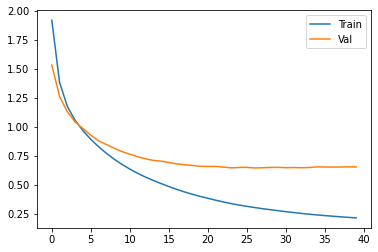

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], label='Val')
plt.legend(['Train', 'Val'])
plt.show()

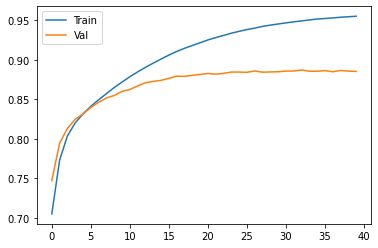

In [27]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Train', 'Val'])
plt.show()

### 4. 모델 구현하기
---
- 단어 단위의 번역기 모델

In [28]:
encoder_model = Model(inputs=encoder_inputs, outputs=encoder_states)
encoder_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 256)         1193472   
_________________________________________________________________
masking_2 (Masking)          (None, None, 256)         0         
_________________________________________________________________
lstm_2 (LSTM)                [(None, 256), (None, 256) 525312    
Total params: 1,718,784
Trainable params: 1,718,784
Non-trainable params: 0
_________________________________________________________________


In [30]:
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = Embedding(fra_vocab_size, 256)(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

decoder_outputs2 = decoder_softmax_layer(decoder_outputs2)

In [33]:
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs2] + decoder_states2)
decoder_model.summary()

Model: "functional_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, None, 256)    1875456     input_4[0][0]                    
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 256)]        0                                            
_______________________________________________________________________________________

In [34]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [39]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = fra2idx['<start>']
    
    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]
        
        decoded_sentence += ' ' + sampled_char
        
        if(sampled_char == '<end>' or len(decoded_sentence) > max_fra_len):
            stop_condition = True
            
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        
        states_value = [h, c]
        
    return decoded_sentence

In [40]:
def seq2src(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + idx2eng[i] + ' '
    return temp

def seq2tar(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=fra2idx['<start>']) and i!=fra2idx['<end>']):
            temp = temp + idx2fra[i] + ' '
    return temp

### 5. 모델 평가하기
---

In [41]:
for seq_index in [22,330,540,770,980]:
    input_seq = encoder_input_test[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', seq2src(encoder_input_test[seq_index]))
    print('정답 문장:', seq2tar(decoder_input_test[seq_index]))
    print('번역 문장:', decoded_sentence[:len(decoded_sentence)-1])

-----------------------------------
입력 문장: can you drive a car ? 
정답 문장: sais tu conduire ? 
번역 문장:  pouvez tu une un
-----------------------------------
입력 문장: don t fire anyone . 
정답 문장: ne virez personne ! 
번역 문장:  n de l pas . . . 
-----------------------------------
입력 문장: give me a sec . 
정답 문장: donnez moi une seconde . 
번역 문장:  donne moi moi un e
-----------------------------------
입력 문장: it wasn t that big . 
정답 문장: il n tait pas si gros . 
번역 문장:  ce n n si si si 
-----------------------------------
입력 문장: he ran out of money . 
정답 문장: il a t court d argent . 
번역 문장:  il il ne une d d u
